In [1]:
%matplotlib inline

from __future__ import division

from datetime import timedelta
import json

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
# Plot formatting
PLOT_DPI = 220
matplotlib.rcParams['axes.color_cycle'] = ['#d73027']

def format_plot(ax):
    ax.xaxis.grid(False)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel('')
    return ax

In [3]:
# Load the data (already sorted by 'when' column)
filename = 'results.csv'
df = pd.read_csv(filename, parse_dates=[0])

In [4]:
# Assign the correct types to each column
df.datacentre = df.datacentre.astype('category')
df.response_status = df.response_status.astype('category')
df.host = df.host.astype('category')
df.is_cache_hit = df.is_cache_hit.astype('bool')
df.content_encoding = df.content_encoding.astype('category')
df.dtypes

when                datetime64[ns]
datacentre                category
response_status           category
ttfb                       float64
ttlb                       float64
host                      category
cache_header                object
is_cache_hit                  bool
content_encoding          category
content_length             float64
exception                   object
dtype: object

In [5]:
# Convert to ms
df.ttfb = df.ttfb * 1000
df.ttlb = df.ttlb * 1000

In [6]:
# Summary stats
n_hosts = len(df.host.unique())
n_requests = len(df)
print 'Number of hosts:', n_hosts
print 'Number of requests:', n_requests
print 'Requests / host / day: ', int(n_requests / n_hosts / 14)
print 'Difference between TTLB and TTFB means [ms]:', df.ttlb.mean() - df.ttfb.mean()
print 'SD of TTLB and TTFB [ms]:', df.ttfb.std(), df.ttfb.std()

Number of hosts: 10
Number of requests: 588784
Requests / host / day:  4205
Difference between TTLB and TTFB means [ms]: 0.488805660639
SD of TTLB and TTFB [ms]: 479.327608996 479.327608996


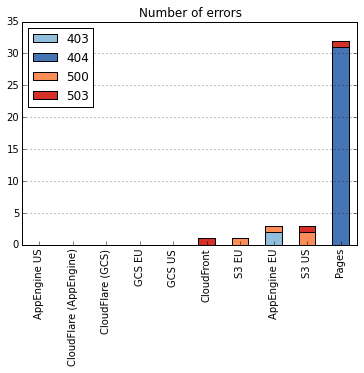

In [7]:
# Errors
error_codes = [403, 404, 500, 503]
colors = ['#91bfdb', '#4575b4','#fc8d59', '#d73027']
results = pd.concat({c:df[df.response_status == c].host.value_counts() for c in error_codes}, axis=1)

results['n_errors'] = sum([results[c] for c in error_codes])
results.sort('n_errors', inplace=True)
results.drop('n_errors', axis=1, inplace=True)

ax = results.plot(kind='bar', stacked=True, color=colors)
ax = format_plot(ax)
ax.set_title('Number of errors')
plt.savefig('images/all_errors.png', dpi=PLOT_DPI, bbox_inches='tight')

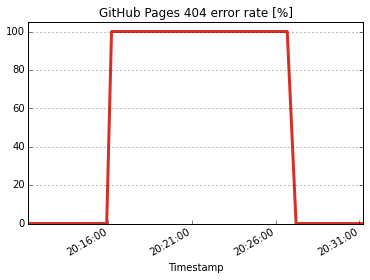

In [8]:
# Github 404 errors over time
results = df.copy()[(df.host=='Pages')]
results.set_index('when', inplace=True)

results['error_rate'] = (results.response_status != 200) & (~results.response_status.isnull())
results['error_rate'] = results.error_rate.astype('int') * 100

min_ = results[results.response_status == 404].index.min() - timedelta(minutes=5)
max_ = results[results.response_status == 404].index.max() + timedelta(minutes=5)
results = results.truncate(before=min_, after=max_)

ax = results.error_rate.plot(linewidth=3)
ax = format_plot(ax)
ax.set_xlabel('Timestamp')
ax.set_ylim([0, 105])
ax.set_title('GitHub Pages 404 error rate [%]')
plt.savefig('images/gh-error-rate.png', dpi=PLOT_DPI, bbox_inches='tight')

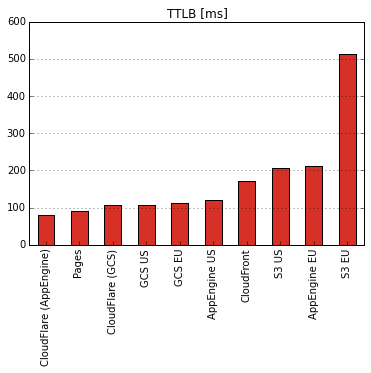

In [9]:
# TTLB
results = df.groupby('host').mean().sort('ttlb', inplace=False)
results = results.ttlb

ax = results.plot(kind='bar')
ax = format_plot(ax)
ax.set_title('TTLB [ms]')
plt.savefig('images/ttlb-host.png', dpi=PLOT_DPI, bbox_inches='tight')

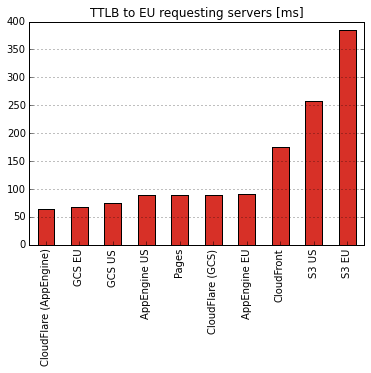

In [10]:
# Europe only
results = df[(df.datacentre == 'linode-frankfurt') | (df.datacentre == 'digital-ocean-london-1')].groupby('host').mean().sort('ttlb', inplace=False)
results = results.ttlb

ax = results.plot(kind='bar')
ax = format_plot(ax)
ax.set_title('TTLB to EU requesting servers [ms]')
plt.savefig('images/ttlb-eu.png', dpi=PLOT_DPI, bbox_inches='tight')

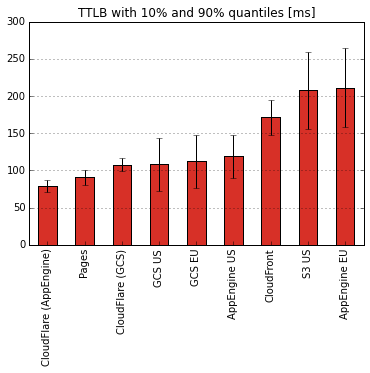

In [11]:
# TTLB without S3 EU
df_no_s3_eu = df.copy()[df.host != 'S3 EU']
df_no_s3_eu.host = df_no_s3_eu.host.cat.remove_unused_categories()

results = df_no_s3_eu.groupby('host').mean()
results.ttlb = results.ttlb

q90 = df_no_s3_eu.groupby('host').ttlb.quantile(0.9)
results['q90'] = q90

q10 = df_no_s3_eu.groupby('host').ttlb.quantile(0.1)
results['q10'] = q10

results.sort('ttlb', inplace=True)

ax = results.ttlb.plot(kind='bar', yerr=[results.q10, results.q90])
ax = format_plot(ax)
ax.set_title('TTLB with 10% and 90% quantiles [ms]')
plt.savefig('images/ttlb-host-no-s3.png', dpi=PLOT_DPI, bbox_inches='tight')

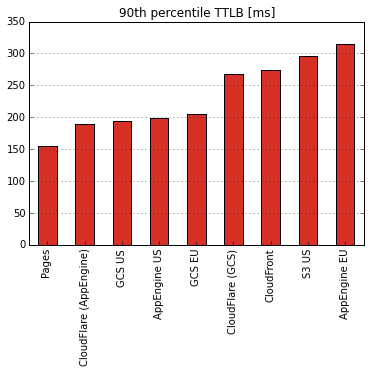

In [12]:
# 90th percentile
results = df_no_s3_eu[df_no_s3_eu.response_status == 200].groupby('host').ttlb.quantile(0.9)
results.sort('ttlb')

ax = results.plot(kind='bar')
ax = format_plot(ax)
ax.set_title('90th percentile TTLB [ms]')
plt.savefig('images/ttlb-90.png', dpi=PLOT_DPI, bbox_inches='tight')

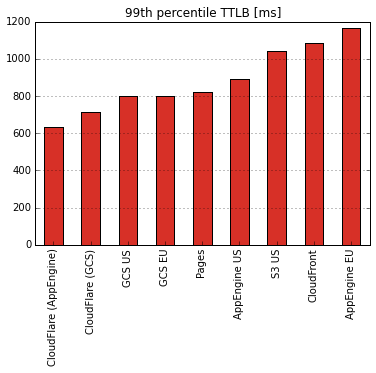

In [13]:
# 99th percentile
results = df_no_s3_eu[df_no_s3_eu.response_status == 200].groupby('host').ttlb.quantile(0.99)
results.sort('ttlb')

ax = results.plot(kind='bar')
ax = format_plot(ax)
ax.set_title('99th percentile TTLB [ms]')
plt.savefig('images/ttlb-99.png', dpi=PLOT_DPI, bbox_inches='tight')

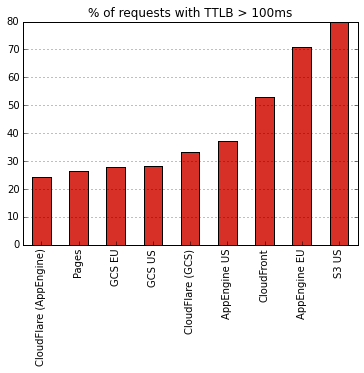

In [14]:
# Short requests
results = df_no_s3_eu[df_no_s3_eu.ttlb > 100].groupby('host').ttlb.count()
results = results / df_no_s3_eu.groupby('host').ttlb.count() * 100
results.sort()
ax = results.plot(kind='bar')
ax = format_plot(ax)
ax.set_title('% of requests with TTLB > 100ms')
plt.savefig('images/short-requests.png', dpi=PLOT_DPI, bbox_inches='tight')

In [15]:
# % Cache misses
print 'CloudFlare:', 100 * (1-df[(df.host=='CloudFlare (AppEngine)') | (df.host=='CloudFlare (GCS)')].is_cache_hit.mean())
print 'Pages:', 100 * (1-df[df.host=='Pages'].is_cache_hit.mean())
cfr = (1-df[df.host=='CloudFront'].is_cache_hit.mean())
print 'CloudFront:', 100 * cfr
print 'Time between CloudFront misses [s]:', (df.when.max()-df.when.min()).total_seconds() / len(df[df.host=='CloudFront']) / cfr / 60

CloudFlare: 0.108701190618
Pages: 0.324394096367
CloudFront: 1.95319134481
Time between CloudFront misses [s]: 17.530405109
